In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[15:29]) == "AOI_4_Shanghai"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img4094.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img506.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img1874.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img1456.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_4_Shanghai_img7054.tif')]

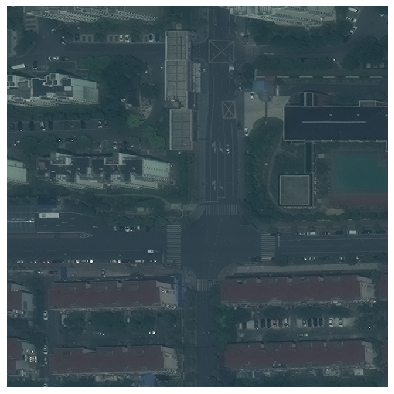

In [6]:
img = open_image(fname[11])
img.show(figsize=(7,7))

In [6]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [7]:
# ref_img = [x for x in fname if list(open_mask(get_y_fn(x)).data.unique()) == list(tensor([0,1]))]

# string = 'Images/'
# data = [string + x.name for x in ref_img]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Shanghai_C_buildings.csv")

In [8]:
shanghai_df = pd.read_csv(path/'Shanghai_C_buildings.csv')
shanghai_df = shanghai_df.drop(columns = 'Unnamed: 0')
shanghai_df.head()

,Images
0,Images/RGB-PanSharpen_AOI_4_Shanghai_img4094.tif
1,Images/RGB-PanSharpen_AOI_4_Shanghai_img506.tif
2,Images/RGB-PanSharpen_AOI_4_Shanghai_img1874.tif
3,Images/RGB-PanSharpen_AOI_4_Shanghai_img7054.tif
4,Images/RGB-PanSharpen_AOI_4_Shanghai_img5101.tif


In [9]:
len(shanghai_df)

3351

In [10]:
sh_df = pd.read_csv(path/'Shanghai_buildings.csv')
sh_df = sh_df.drop(columns = 'Unnamed: 0')
len(sh_df)

4582

In [11]:
cut_df = sh_df.append(shanghai_df).drop_duplicates(keep=False)
len(cut_df)

1231

In [12]:
shanghai_df = shanghai_df.append(cut_df[:249])
len(shanghai_df)

3600

In [13]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [14]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(shanghai_df, path).
      split_by_rand_pct(.08).
      label_from_func(get_y_fn, classes=codes))

In [14]:
bs = 64
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.3, max_lighting = 0.5, max_warp=None,
                                     xtra_tfms = [brightness(change=0.70, p=1), contrast(scale=(1.25, 1.5), p=1.)]), 
                      size = size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

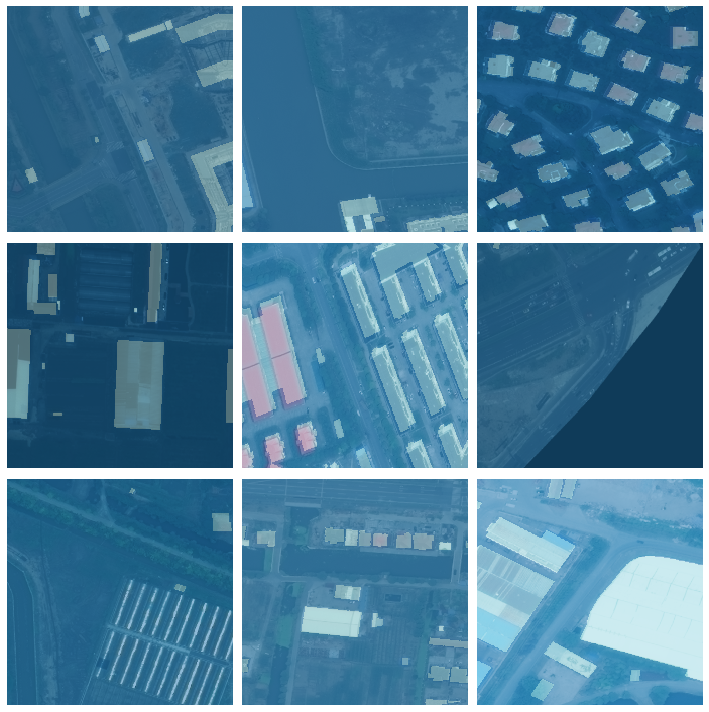

In [15]:
data.show_batch(3, figsize=(10,10))

In [16]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight, 
                     self_attention = True).to_fp16()
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


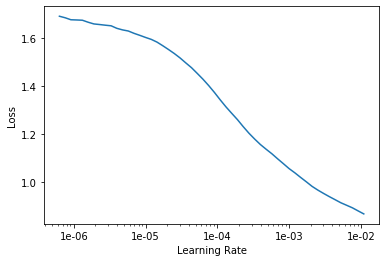

In [17]:
learn.lr_find()
learn.recorder.plot() 

In [18]:
learn.fit_one_cycle(10, slice(5e-4))

epoch,train_loss,valid_loss,dice,time
0,0.591953,0.330905,0.014582,00:38
1,0.381134,0.237254,0.426612,00:36
2,0.297397,0.224177,0.281598,00:36
3,0.253102,0.209132,0.450918,00:36
4,0.223203,0.172771,0.523751,00:37
5,0.208052,0.174690,0.591503,00:36
6,0.195705,0.156450,0.597149,00:36
7,0.185398,0.154713,0.601203,00:37
8,0.178811,0.149623,0.616109,00:35
9,0.174129,0.150958,0.614914,00:36


In [19]:
save_model(learn, 'Shanghai_DAC', 'F', 'smol', 1)

# Start Recording

In [15]:
import wandb
from wandb.fastai import WandbCallback

In [22]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [23]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Shanghai.ipynb"

In [24]:
wandb.init(project="spacenet_buildings", name = 'Shanghai_DAC')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/kuk6zwu7

In [25]:
load_model(learn, 'Shanghai_DAC', 'F', 'smol', 1)

In [26]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.174075,0.149663,0.619077,00:37
1,0.172027,0.148261,0.623026,00:36
2,0.176835,0.153984,0.585516,00:37
3,0.183067,0.148595,0.602778,00:37
4,0.189840,0.158147,0.620304,00:37
5,0.188231,0.156256,0.582116,00:37
6,0.179942,0.174829,0.624886,00:37
7,0.172749,0.142153,0.635510,00:37
8,0.165435,0.136457,0.643071,00:36
9,0.157819,0.133743,0.657612,00:37


Better model found at epoch 0 with valid_loss value: 0.14966344833374023.
Better model found at epoch 1 with valid_loss value: 0.14826101064682007.
Better model found at epoch 7 with valid_loss value: 0.14215299487113953.
Better model found at epoch 8 with valid_loss value: 0.13645747303962708.
Better model found at epoch 9 with valid_loss value: 0.13374263048171997.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200126_101538-kuk6zwu7/bestmodel.pth


In [28]:
save_model(learn, 'Shanghai_DAC', 'F', 'smol', 2)

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.148021,0.133794,0.658849,00:37
1,0.149520,0.132261,0.661177,00:38
2,0.149998,0.133148,0.661248,00:38
3,0.149252,0.131077,0.658778,00:37
4,0.147704,0.130071,0.661853,00:37
5,0.146624,0.129902,0.670145,00:38
6,0.145403,0.129110,0.663354,00:38
7,0.143997,0.131012,0.670650,00:38
8,0.142738,0.128246,0.669831,00:38
9,0.141471,0.127534,0.670482,00:38


Better model found at epoch 0 with valid_loss value: 0.13379357755184174.
Better model found at epoch 1 with valid_loss value: 0.13226060569286346.
Better model found at epoch 3 with valid_loss value: 0.13107715547084808.
Better model found at epoch 4 with valid_loss value: 0.1300714761018753.
Better model found at epoch 5 with valid_loss value: 0.12990213930606842.
Better model found at epoch 6 with valid_loss value: 0.12910984456539154.
Better model found at epoch 8 with valid_loss value: 0.12824635207653046.
Better model found at epoch 9 with valid_loss value: 0.12753397226333618.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200126_101538-kuk6zwu7/bestmodel.pth


In [31]:
save_model(learn, 'Shanghai_DAC', 'UF', 'smol', 1)

In [32]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.140230,0.128486,0.669608,00:38
1,0.141045,0.127340,0.669428,00:39
2,0.140118,0.126760,0.671439,00:38
3,0.140116,0.127054,0.670269,00:39
4,0.139506,0.126268,0.673156,00:38
5,0.139175,0.126452,0.671239,00:38
6,0.139636,0.126205,0.671014,00:38
7,0.138623,0.126278,0.672427,00:38
8,0.138275,0.125935,0.673556,00:37
9,0.138897,0.126088,0.672518,00:38


Better model found at epoch 0 with valid_loss value: 0.12848636507987976.
Better model found at epoch 1 with valid_loss value: 0.1273399293422699.
Better model found at epoch 2 with valid_loss value: 0.12675966322422028.
Better model found at epoch 4 with valid_loss value: 0.12626780569553375.
Better model found at epoch 8 with valid_loss value: 0.1259346753358841.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200126_101538-kuk6zwu7/bestmodel.pth


In [33]:
save_model(learn, 'Shanghai_DAC', 'UF', 'smol', 2)

## GO BIG

In [16]:
bs = 16
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.3, max_lighting = 0.5, max_warp=None,
                                     xtra_tfms = [brightness(change=0.70, p=1), contrast(scale=(1.25, 1.5), p=1.)]), 
                      size = size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

In [17]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [18]:
load_model(learn, 'Shanghai_DAC', 'UF', 'smol', 2)

In [19]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Shanghai.ipynb"

In [20]:
wandb.init(project="spacenet_buildings", name = 'Shanghai_DAC')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/b8o8ysuo

In [21]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.152098,0.128139,0.689789,01:58
1,0.153284,0.131369,0.680787,01:45
2,0.154424,0.129087,0.689691,01:45
3,0.151530,0.136514,0.680218,01:45
4,0.151162,0.137593,0.683408,01:45
5,0.154536,0.145781,0.643098,01:45
6,0.163306,0.136334,0.686272,01:45
7,0.144486,0.125818,0.700781,01:45
8,0.131168,0.123929,0.705750,01:45
9,0.126436,0.119312,0.709276,01:45


Better model found at epoch 0 with valid_loss value: 0.12813851237297058.
Better model found at epoch 7 with valid_loss value: 0.12581750750541687.
Better model found at epoch 8 with valid_loss value: 0.12392900884151459.
Better model found at epoch 9 with valid_loss value: 0.11931174248456955.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200126_105731-b8o8ysuo/bestmodel.pth


In [22]:
save_model(learn, 'Shanghai_DAC', 'F', 'big', 1)

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(5, slice(1e-4), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.124001,0.119882,0.704115,01:46
1,0.126904,0.117410,0.712340,01:45
2,0.123262,0.115883,0.723500,01:46
3,0.128771,0.115379,0.713323,01:46
4,0.120349,0.114523,0.720487,01:47


Better model found at epoch 0 with valid_loss value: 0.11988230794668198.
Better model found at epoch 1 with valid_loss value: 0.11741040647029877.
Better model found at epoch 2 with valid_loss value: 0.1158829927444458.
Better model found at epoch 3 with valid_loss value: 0.11537908017635345.
Better model found at epoch 4 with valid_loss value: 0.11452346295118332.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200126_105731-b8o8ysuo/bestmodel.pth


In [25]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.117059,0.115916,0.716124,01:46
1,0.120903,0.115615,0.717351,01:46
2,0.120677,0.116236,0.714929,01:46
3,0.121483,0.117242,0.721460,01:46
4,0.121612,0.114426,0.715601,01:47
5,0.123512,0.118257,0.710756,01:46
6,0.121728,0.119297,0.704020,01:46
7,0.118036,0.113610,0.721267,01:46
8,0.114487,0.114189,0.721979,01:47
9,0.111577,0.112446,0.724153,01:46


Better model found at epoch 0 with valid_loss value: 0.11591586470603943.
Better model found at epoch 1 with valid_loss value: 0.11561451852321625.
Better model found at epoch 4 with valid_loss value: 0.1144256740808487.
Better model found at epoch 7 with valid_loss value: 0.1136099249124527.
Better model found at epoch 9 with valid_loss value: 0.11244598776102066.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200126_105731-b8o8ysuo/bestmodel.pth


In [26]:
save_model(learn, 'Shanghai_DAC', 'UF', 'big', 1)

In [27]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.114645,0.111856,0.726209,01:46
1,0.113424,0.112282,0.725284,01:46
2,0.115158,0.112460,0.727302,01:47
3,0.115003,0.111489,0.728022,01:46
4,0.112616,0.112707,0.723236,01:46
5,0.112488,0.112290,0.727850,01:46
6,0.110484,0.112169,0.726961,01:47
7,0.114503,0.111911,0.731532,01:47
8,0.114940,0.109832,0.731711,01:46
9,0.108496,0.110107,0.730823,01:45


Better model found at epoch 0 with valid_loss value: 0.11185649037361145.
Better model found at epoch 3 with valid_loss value: 0.11148933321237564.
Better model found at epoch 8 with valid_loss value: 0.10983210802078247.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200126_105731-b8o8ysuo/bestmodel.pth


In [28]:
save_model(learn, 'Shanghai_DAC', 'UF', 'big', 2)

In [29]:
learn.fit_one_cycle(10, slice(5e-7, 5e-6), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.110773,0.109066,0.733043,01:47
1,0.107013,0.109708,0.731302,01:46
2,0.106306,0.110211,0.730108,01:46
3,0.111174,0.109617,0.732075,01:46
4,0.109374,0.111040,0.728179,01:46
5,0.111428,0.109590,0.730810,01:46
6,0.109770,0.109824,0.730895,01:48
7,0.109646,0.109751,0.730303,01:46
8,0.107490,0.109779,0.731226,01:46
9,0.106446,0.109412,0.732205,01:46


Better model found at epoch 0 with valid_loss value: 0.10906586050987244.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200126_105731-b8o8ysuo/bestmodel.pth


In [30]:
save_model(learn, 'Shanghai_DAC', 'UF', 'big', 3)